In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin50_twin'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPEsub_rall'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG100-1/geometric_features_nstarpartmin50_twin_xminPEsub_rall.npy


In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [5]:
n_groups = [[0,1,2], [3,4,5,6,7], [8,9,10]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)
geo_feature_arr_pseudo = utils.transform_pseudotensors(geo_feature_arr_rebinned)

In [43]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [44]:
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')

sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')

In [8]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
log_r_200m = np.log10(r_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 19810


# Check out Mgas

In [33]:
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_gas')
m_gas = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_gas'] for dark_halo in sim_reader.dark_halo_arr])

In [34]:
m_gas_zero_val = 1e5
small = 1e-6
m_gas[abs(m_gas)<small] = m_gas_zero_val

In [35]:
log_m_gas = np.log10(m_gas)

In [38]:
print(np.min(log_m_gas), np.max(log_m_gas))

-3.8579097 5.0


Text(0, 0.5, 'number per bin')

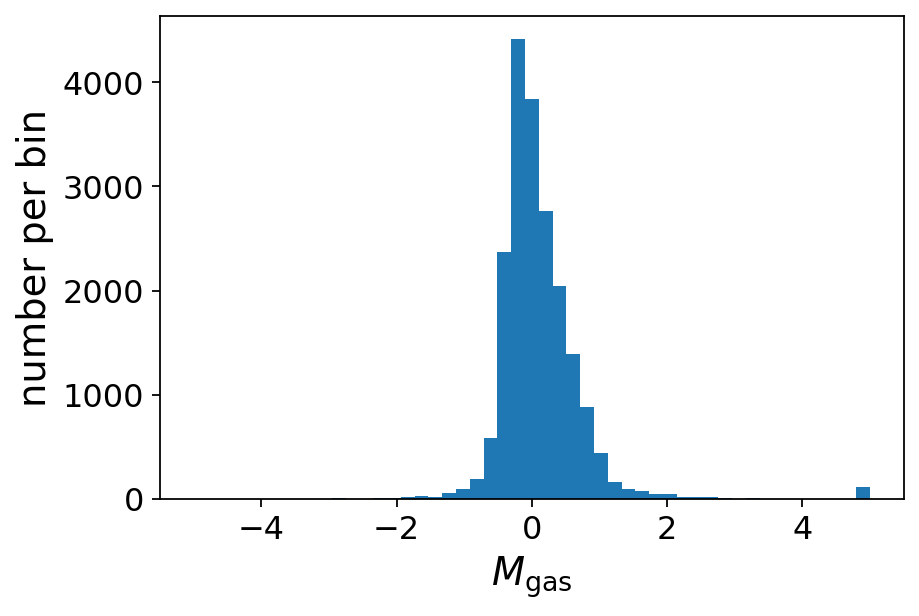

In [41]:
bins = np.linspace(-5, 5, 50)
plt.hist(log_m_gas, bins=bins)
plt.xlabel(r'$M_\mathrm{gas}$')
plt.ylabel('number per bin')

# Check out velocity dispersion

In [45]:
sim_reader.add_catalog_property_to_halos('velocity_dispersion')
v_disp = np.array([dark_halo.catalog_properties['velocity_dispersion'] for dark_halo in sim_reader.dark_halo_arr])

In [46]:
print(np.min(v_disp), np.max(v_disp))

27.471031 603.87506


In [49]:
log_v_disp = np.log10(v_disp)
print(np.min(log_v_disp), np.max(log_v_disp))

1.438875 2.7809472


Text(0, 0.5, 'number per bin')

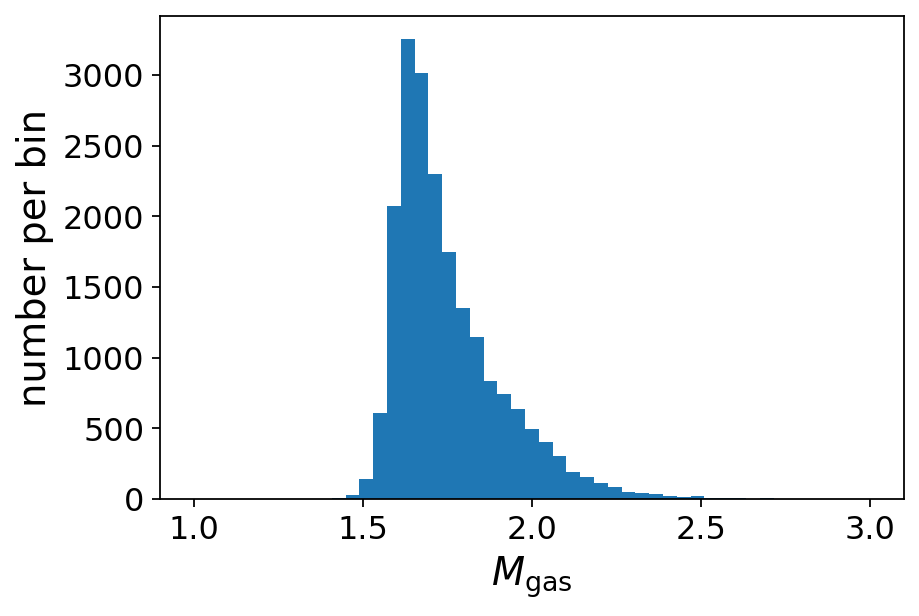

In [50]:
bins = np.linspace(1, 3, 50)
plt.hist(log_v_disp, bins=bins)
plt.xlabel(r'$M_\mathrm{gas}$')
plt.ylabel('number per bin')